In [1]:
# HELPER FUNCTIONS

import collections

def get_mean_metrics(models, metric_type):
    mean_acc_fedavg = []
    for model in models["result"]:
        model_id = model["model"]
        validations = client.list_validations(modelId=model_id)

        acc = []
        for _, validation in validations.items(): 
            metrics = json.loads(validation['data'])
            if metric_type in metrics:
                acc.append(metrics[metric_type])

        if acc:
            mean_acc_fedavg.append(np.mean(acc))

    return np.min(mean_acc_fedavg) if 'loss' in metric_type else np.max(mean_acc_fedavg)

def get_baseline_metrics(baseline_session_id):
    models = client.list_models(baseline_session_id)

    baseline_metrics = {
        'training_loss': get_mean_metrics(models, 'training_loss'),
        'training_accuracy': get_mean_metrics(models, 'training_accuracy'),
        'test_loss': get_mean_metrics(models, 'test_loss'),
        'test_accuracy': get_mean_metrics(models, 'test_accuracy')
    }

    return baseline_metrics

In [2]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

In [3]:
DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [4]:
[session['session_id'] for session in client.list_sessions()['result']]

['MNIST_GBP010_25R_16_04',
 'MNIST_GBP010_25R_18_02',
 'MNIST_GBP010_25R_19_01',
 'MNIST_LFB_25R_16_04_V2',
 'MNIST_LFB_25R_18_02_V2',
 'MNIST_LFB_25R_19_01_V2',
 'TEST_5_WITH_EPOCH_01',
 'TEST_EPOCH_04',
 'TEST_EPOCH_03',
 'TEST_EPOCH_02',
 'TEST_EPOCH_01',
 'MNIST_GBM001_25R_18_02',
 'MNIST_GBM001_25R_19_01',
 'MNIST_BASE_25R_20_00']

In [5]:
session_id = input("Provide a session_id: ")

Provide a session_id:  MNIST_GBP010_25R_16_04


In [6]:
# baseline_session_id = input("Provide baseline session_id: ")

In [7]:
baseline_metrics = get_baseline_metrics(input("Provide baseline session_id: "))

Provide baseline session_id:  MNIST_BASE_25R_20_00


In [8]:
models = client.list_models(session_id)
# models

In [9]:
num_rounds = models['count']
# num_rounds

In [10]:
# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [11]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'training_loss': json.loads(worker_result['data'])['training_loss'],
            'training_accuracy': json.loads(worker_result['data'])['training_accuracy'],
            'test_loss': json.loads(worker_result['data'])['test_loss'],
            'test_accuracy': json.loads(worker_result['data'])['test_accuracy']
        }
        
        validations.append(validation)
        

In [12]:
# validations

In [13]:
# set([validation['client_name'] for validation in validations])

In [14]:
graph_data = {
    'training_loss': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'training_accuracy': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_loss': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_accuracy': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_training_loss': [],
    'overall_training_accuracy': [],
    'overall_test_loss': [],
    'overall_test_accuracy': []
}

In [15]:
for validation in validations:
    graph_data['training_loss'][validation['client_name']]['data'].append(validation['training_loss'])
    graph_data['training_accuracy'][validation['client_name']]['data'].append(validation['training_accuracy'])
    graph_data['test_loss'][validation['client_name']]['data'].append(validation['test_loss'])
    graph_data['test_accuracy'][validation['client_name']]['data'].append(validation['test_accuracy'])

In [16]:
graph_data['overall_training_loss'] = [np.mean([graph_data['training_loss'][key]['data'][i] for key in graph_data['training_loss'].keys()]) for i in range(num_rounds)]
graph_data['overall_training_accuracy'] = [np.mean([graph_data['training_accuracy'][key]['data'][i] for key in graph_data['training_accuracy'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_loss'] = [np.mean([graph_data['test_loss'][key]['data'][i] for key in graph_data['test_loss'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_accuracy'] = [np.mean([graph_data['test_accuracy'][key]['data'][i] for key in graph_data['test_accuracy'].keys()]) for i in range(num_rounds)]

In [17]:
# graph_data

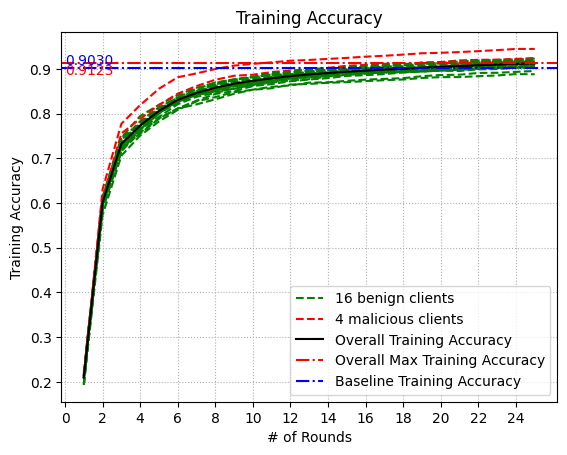

In [25]:
x = range(1, num_rounds + 1)
metric_type = "training_accuracy"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
if 'loss' in metric_type:
    plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
    plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')
else:
    plt.axhline(y=np.max(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Max {metric_type.replace("_", " ").title()}')
    plt.text(0, np.max(graph_data[f'overall_{metric_type}']), f'{np.max(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='top', color='red')
plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

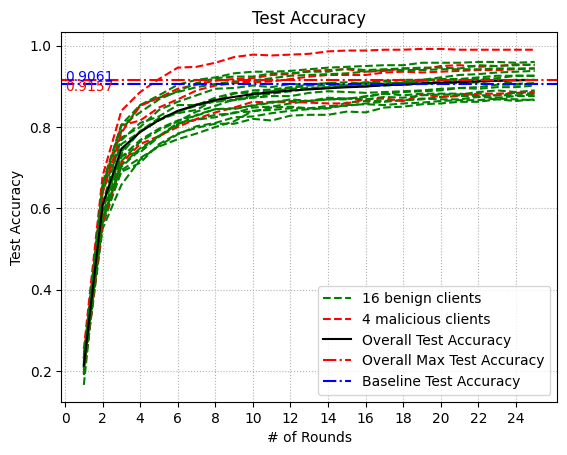

In [19]:
x = range(1, num_rounds + 1)
metric_type = "test_accuracy"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
if 'loss' in metric_type:
    plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
    plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')
else:
    plt.axhline(y=np.max(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Max {metric_type.replace("_", " ").title()}')
    plt.text(0, np.max(graph_data[f'overall_{metric_type}']), f'{np.max(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='top', color='red')
plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

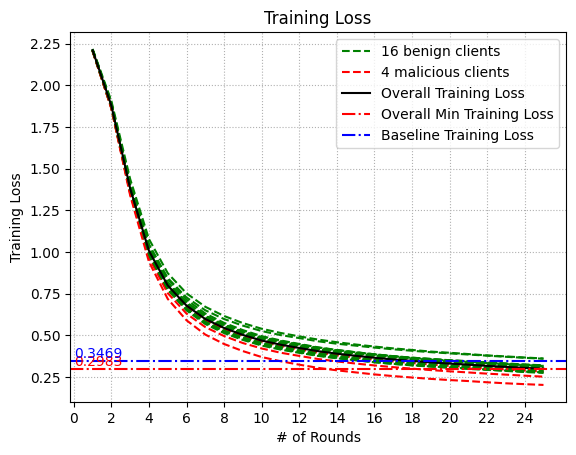

In [23]:
x = range(1, num_rounds + 1)
metric_type = "training_loss"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
if 'loss' in metric_type:
    plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
    plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')
else:
    plt.axhline(y=np.max(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Max {metric_type.replace("_", " ").title()}')
    plt.text(0, np.max(graph_data[f'overall_{metric_type}']), f'{np.max(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')
plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

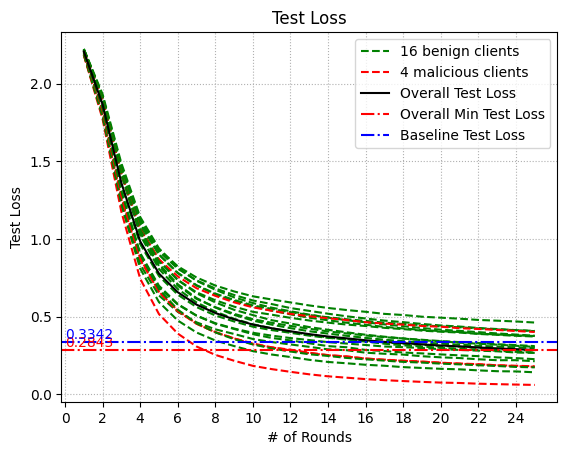

In [24]:
x = range(1, num_rounds + 1)
metric_type = "test_loss"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
if 'loss' in metric_type:
    plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
    plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')
else:
    plt.axhline(y=np.max(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Max {metric_type.replace("_", " ").title()}')
    plt.text(0, np.max(graph_data[f'overall_{metric_type}']), f'{np.max(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')
plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()


## To create a grid output

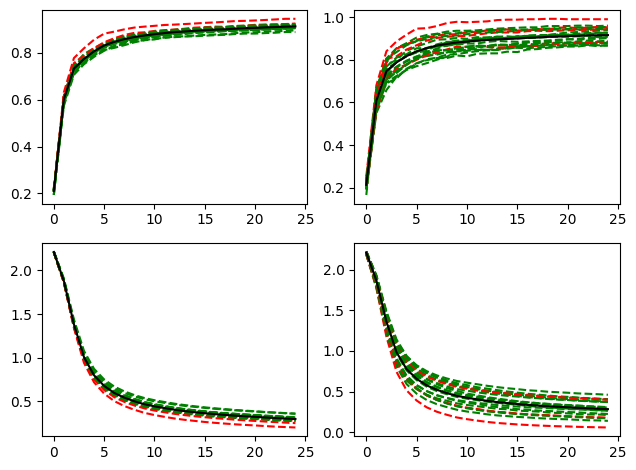

In [22]:
import matplotlib.pyplot as plt

def plot_1(ax):
    x = range(num_rounds)
    metric_type = "training_accuracy"

    for i in range(len(graph_data[metric_type])):
        if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        else:
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')

    ax.plot(x, graph_data[f'overall_{metric_type}'], color='black')

def plot_2(ax):
    x = range(num_rounds)
    metric_type = "test_accuracy"

    for i in range(len(graph_data[metric_type])):
        if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        else:
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')

    ax.plot(x, graph_data[f'overall_{metric_type}'], color='black')

def plot_3(ax):
    x = range(num_rounds)
    metric_type = "training_loss"

    for i in range(len(graph_data[metric_type])):
        if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        else:
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')

    ax.plot(x, graph_data[f'overall_{metric_type}'], color='black')

def plot_4(ax):
    x = range(num_rounds)
    metric_type = "test_loss"

    for i in range(len(graph_data[metric_type])):
        if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        else:
            ax.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')

    ax.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Plot each function in a separate subplot
plot_funcs = [plot_1, plot_2, plot_3, plot_4]

for i in range(2):
    for j in range(2):
        plot_funcs[i * 2 + j](axs[i, j])

# Adjust layout
plt.tight_layout()

# Create a common legend outside the subplots
# fig.legend([label for label in graph_data["training_accuracy"].keys()] + [f'overall_training_accuracy'], loc='upper right')

# Show plot
plt.show()